# Advanced ML: Домашнее задание 1

Данная работа выполнена в качестве домашнего задания по курсу Advanced Machine Learning в академии больших данных MADE.
В работе проведен анализ скорости распространения коронавирусной инфекции в России в разные периоды развития пандемии.

Источник данных: https://ourworldindata.org/coronavirus-source-data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sps

from sklearn.linear_model import LinearRegression, Ridge

import warnings
warnings.filterwarnings('ignore')

Первоначально проанализируем количество новых случаев заражения короновирусом, а также общее количество случаев в первые 50 дней с момента начала распространения коронавируса в России.
В качестве даты начала распространения взято 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). 
Для упрощения обработки заменим в столбце new_cases все нули на единицы.

### 1. Загрузка данных

In [59]:
data = pd.read_csv('owid-covid-data.csv')
data = data[data.location == 'Russia'][['date', 'total_cases', 'new_cases']]
data['date'] = pd.to_datetime(data['date'])
data = data[data.date >= '2020-03-03 00:00:00'].reset_index(drop = True)
data['new_cases'] = data['new_cases'].apply(lambda x: 1 if x == 0 else x)
data['number_of_the_day'] = np.arange(len(data))
data = data[['date', 'number_of_the_day', 'new_cases', 'total_cases']]
data

,date,number_of_the_day,new_cases,total_cases
0,2020-03-03,0,1.0,3.0
1,2020-03-04,1,1.0,3.0
2,2020-03-05,2,1.0,4.0
3,2020-03-06,3,9.0,13.0
4,2020-03-07,4,1.0,13.0
...,...,...,...,...
709,2022-02-10,709,195293.0,13323972.0
710,2022-02-11,710,202211.0,13526183.0
711,2022-02-12,711,201955.0,13728138.0
712,2022-02-13,712,195813.0,13923951.0


Построим график роста новых случаев заражения(и общего количества случаев) в первые 50 дней с начала распространения вируса в России:

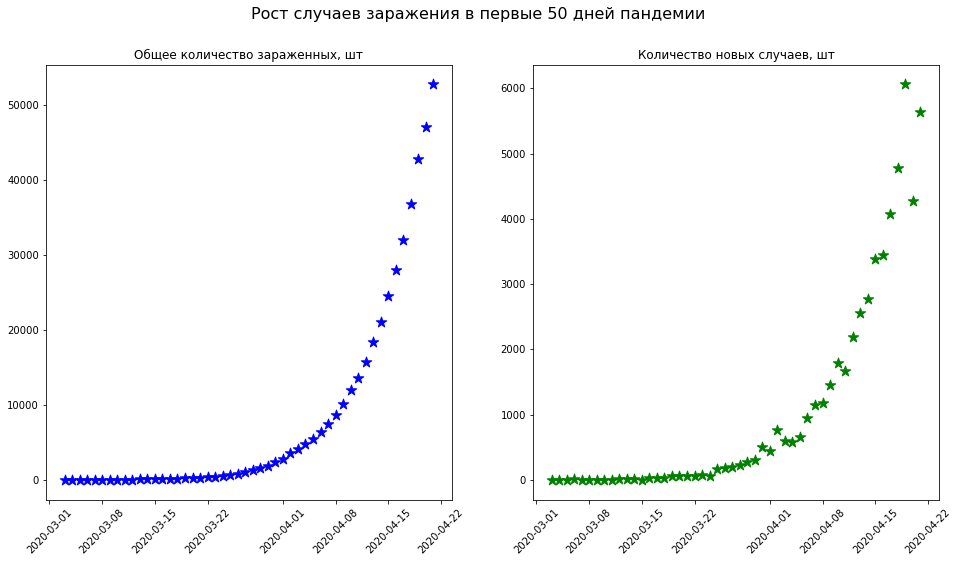

In [60]:
days_for_view = 50
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Рост случаев заражения в первые 50 дней пандемии', size = 16)

ax1.scatter(data.date[:days_for_view], data.total_cases[:days_for_view], marker='*', s=120, color = 'blue')
ax1.set_title('Общее количество зараженных, шт')

ax2.scatter(data.date[:days_for_view], data.new_cases[:days_for_view],  marker='*', s=120, color = 'green')
ax2.set_title('Количество новых случаев, шт')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
plt.show()

Видим очень быстрый рост количества заболевших. Темп роста похож на экспоненциальный.

### 2. Построение экспоненциальной модели, предсказывающей количество выявленных случаев коронавируса. 

***2а. Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.***

Сначала построим прогноз для ежедневного количества новых выявденных случаев:

In [61]:
data['log_new_cases'] = np.log(data['new_cases'])

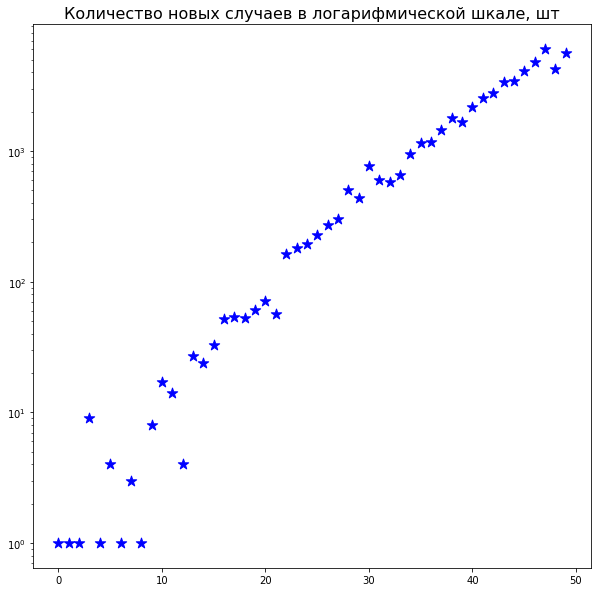

In [62]:
days_for_view = 50
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.scatter(data['number_of_the_day'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax.set_title('Количество новых случаев в логарифмической шкале, шт', size = 16)

ax.set_yscale('log')

Мы видим, что логарифм от количества ежедневно выявляемых новых случаев должен хорошо аппроксимироваться линейной функцией. При этом, в самом начале развития эпидемии(примерно до 10 дня) количество новых случаев было очень маленьким, поэтому был большой разброс значений логарифма. Начиная примерно с 20 дня уже можно говорить о наятоящем экспоненциальном росте.
С точки зрения аппроксимации функции роста наиболее удобным оказалось брать данные, начиная с 20 дня развития эпидемии.

In [63]:
X = np.vstack([data['number_of_the_day'], np.ones(len(data))]).T
y = data['log_new_cases'].values

In [64]:
model_new = LinearRegression()
model_new.fit(X[20:50],y[20:50])
pred_new_cases = np.exp(model_new.predict(X))

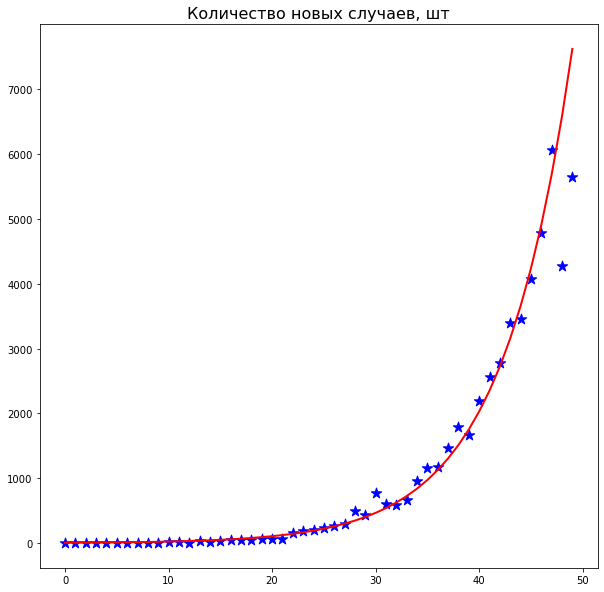

In [65]:
days_for_view = 50
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.scatter(data['number_of_the_day'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax.set_title('Количество новых случаев, шт', size = 16)

ax.plot(data['number_of_the_day'][:days_for_view], pred_new_cases[:days_for_view], linewidth=2, color = 'red');

На графике видно, что количество ежедневно выявляемых новых случаев достаточно хорошо аппроксимируется экспонентой. Сделаем то же самое в отношении общего количества выявленных случаев.

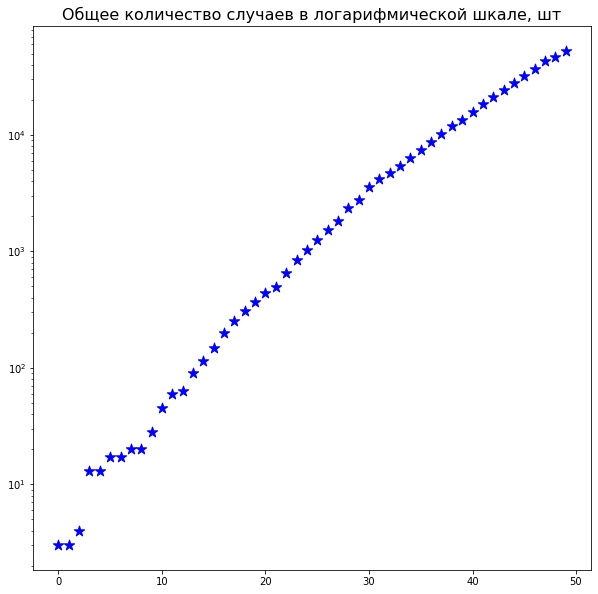

In [66]:
days_for_view = 50
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.scatter(data['number_of_the_day'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax.set_title('Общее количество случаев в логарифмической шкале, шт', size = 16)

ax.set_yscale('log')

In [67]:
data['log_total_cases']=np.log(data['total_cases'])
X_total = np.vstack([data['number_of_the_day'], np.ones(len(data))]).T
y_total = data['log_total_cases']

In [68]:
model_total = LinearRegression()
model_total.fit(X_total[30:50],y_total[30:50])

pred_total_cases = np.exp(model_total.predict(X_total))

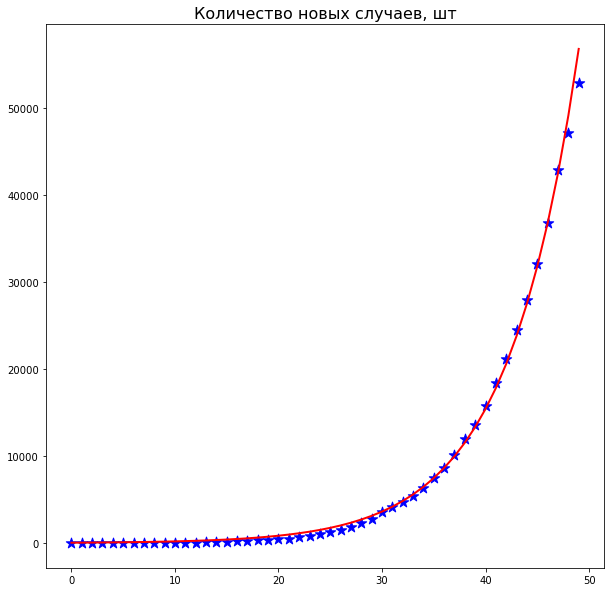

In [69]:
days_for_view = 50
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.scatter(data['number_of_the_day'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax.set_title('Количество новых случаев, шт', size = 16)

ax.plot(data['number_of_the_day'][:days_for_view], pred_total_cases[:days_for_view], linewidth=2, color = 'red');

***2 b.	Нахождение апостериорного распределения параметров этой модели для достаточно широкого априорного распределения.*** 

Дальнейший анализ проведем для целевой переменной 'new_cases' (количество ежедневно выявляемых новых случаев). 
Делаем базовое предположение, что наши данные (в данном случае логарифм количества новых случаев, 'log_new_cases') порождены линейной моделью с шумом. Шум имеет нормальное распределение с центром в нуле и дисперсией  $\sigma$.

Оценим $\sigma$ на основании отклонений реального и спрогнозированного моделью log_new_cases:

In [70]:
data['pred_log_new_cases'] = model_new.predict(X)
data['sigma_emp'] = data['pred_log_new_cases'] - data['log_new_cases']
sigma = data.sigma_emp[:50].std()
sigma

0.8283604864471215

В качестве априорного распределения параметров линейной регрессии возьмем нормальное распределение с центром в нуле и матрицей ковариации
$$\Sigma_{0} = \begin{pmatrix}
  \sigma& 0\\
  0& \sigma
\end{pmatrix}$$:

In [71]:
mu_prior, sigma_prior = np.array([0, 0]), sigma * np.array([[1, 0], [0, 1]])

Учитывая, что нормальное распределение параметров является самосопряженным, апостериорное распределение также является нормальным, среднее значение и дисперсия которого вычисляются по формулам:

$$\Sigma_{post}=(\Sigma_{0}^{-1} + \frac{1}{\sigma^2}X^{T}X)^{-1}$$

$$\mu_{post}=\Sigma_{post}(\Sigma_{0}^{-1}\mu_{0} + \frac{1}{\sigma^2}X^{T}y)$$,

где $\mu_{0}$ и $\Sigma_{0}$ - среднее и дисперсия априорного распределения, а $(X, y)$ - имеющиеся данные.

Вычислим параметры апостериорного распределения:

In [72]:
X1 = X[20:50]
y1 = y[20:50]
sigma_post = np.linalg.inv(np.linalg.inv(sigma_prior) + 1 / sigma**2 * X1.T @ X1)
mu_post = sigma_post @ (np.linalg.inv(sigma_prior) @ mu_prior + 1 / sigma**2 * X1.T@y1)

In [73]:
sigma_post

array([[ 2.13910739e-04, -7.18162145e-03],
       [-7.18162145e-03,  2.63366561e-01]])

In [74]:
mu_post

array([0.16197014, 1.18683385])

Посмотрим, насколько хорошо аппроксимирует имеющиеся данные линейная регрессия параметрами, натболее вероятными для апостериорного распределения ($\mu_{post}$)

In [75]:
pred_post = X @ mu_post

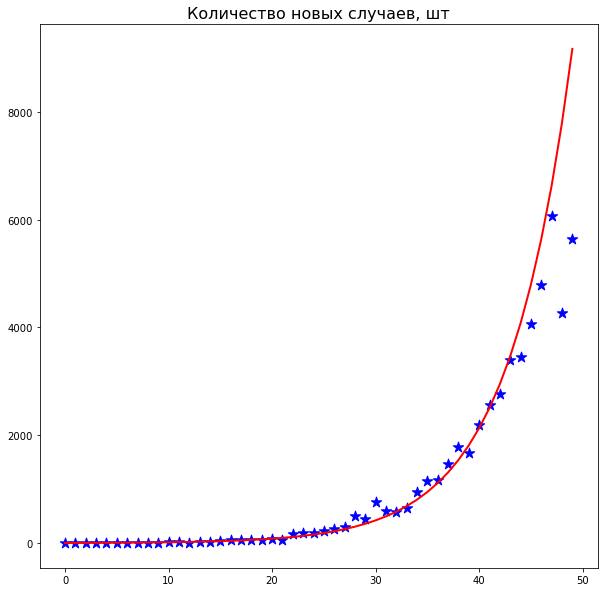

In [76]:
days_for_view = 50
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.scatter(data['number_of_the_day'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax.set_title('Количество новых случаев, шт', size = 16)

ax.plot(data['number_of_the_day'][:days_for_view], np.exp(pred_post)[:days_for_view], linewidth=2, color = 'red');

***2c. Построение предсказательного распределения***

Просэмплируем много разных экспонент из полученного апостериорного распределения параметров линейной регрессии и построим эмпирическое предсказательное распределение (исходя из данных сэмплирования):

In [80]:
def myplot_sample_exponential_model(data, mu, sigma, days_for_view, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111)
    ax.scatter(data['date'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'red')
    ax.set_title('Количество новых случаев, шт', size = 16)
    
    X = np.vstack([data['number_of_the_day'], np.ones(len(data))]).T
    for w in my_w:
        pred_post = X @ w
        ax.plot(data['date'][:days_for_view], np.exp(pred_post)[:days_for_view], linewidth=1, color = 'black')


**Для первых 50 дней с момента начала пандемии:**

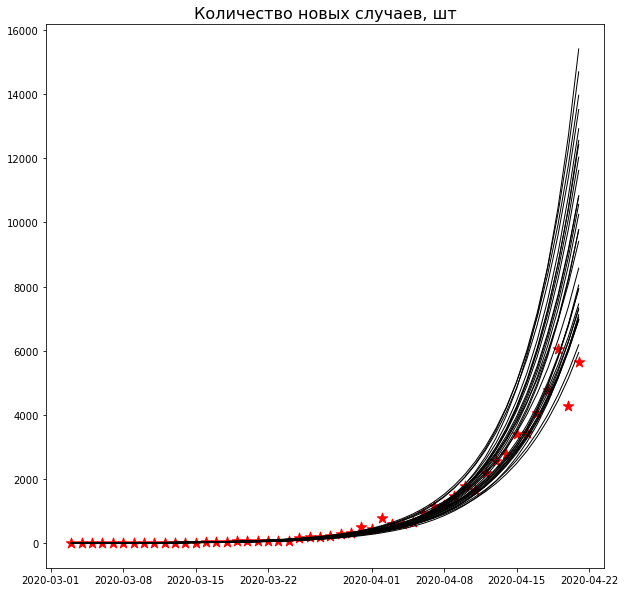

In [81]:
myplot_sample_exponential_model(data, mu_post, sigma_post, 50, 30)

**22 апреля - 10 июня 2020 года:**

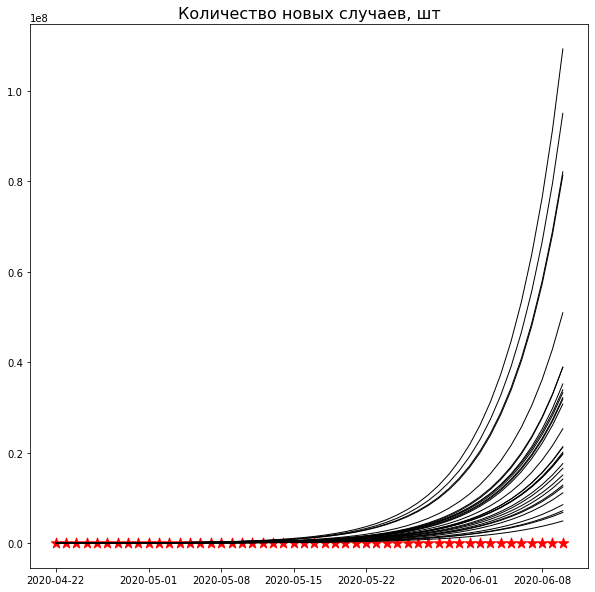

In [82]:
myplot_sample_exponential_model(data[50:], mu_post, sigma_post,50, 30)

Построим предсказательное распределение на основе сэмплирования:

In [83]:
def predictive_dist_exponential_model(data, mu, sigma, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    X = np.vstack([data['number_of_the_day'], np.ones(len(data))]).T
    preds = []
    for w in my_w:
        pred_post = np.exp(X @ w)
        preds.append(pred_post)
    return np.array(preds).mean(axis = 0)

In [84]:
data['pred_exp'] = predictive_dist_exponential_model(data, mu_post, sigma_post, n=100)

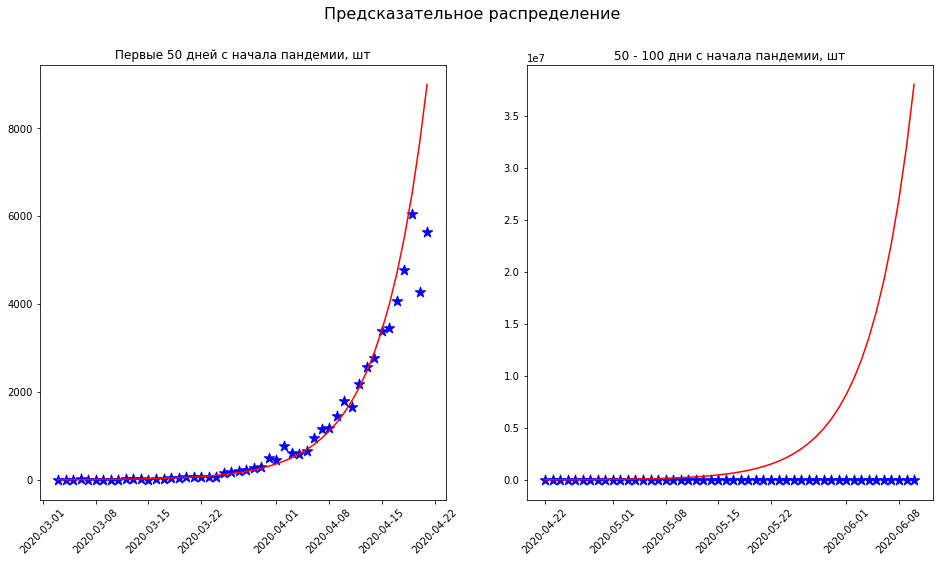

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Предсказательное распределение', size = 16)

ax1.scatter(data.date[:50], data.new_cases[:50], marker='*', s=120, color = 'blue')
ax1.plot(data['date'][:50], data['pred_exp'][:50], color = 'red')
ax1.set_title('Первые 50 дней с начала пандемии, шт')

ax2.scatter(data.date[50:100], data.new_cases[50:100], marker='*', s=120, color = 'blue')
ax2.plot(data['date'][50:100], data['pred_exp'][50:100], color = 'red')
ax2.set_title('50 - 100 дни с начала пандемии, шт')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
plt.show()

Из графиков видно, что количество ежедневно выявляемых новых случаев в начале пандемии достаточно хорошо аппроксимируется нашим предсказательным распределением, а после этого количество предсказанных новых случаев начинает расти гораздо быстрее, чем реальное количество ежедневно выявляемых новых случаев.
Посмотрим на реальные и прогнозные данные на 1.05.2020, 1.06.2020 и 1.09.2020:

In [29]:
data[(data.date == '2020-05-01') | (data.date == '2020-06-01') | (data.date == '2020-09-01')][['date', 'number_of_the_day', 'new_cases', 'pred_exp']]

,date,number_of_the_day,new_cases,pred_exp
59,2020-05-01,59,7933.0,5.032057e+04
90,2020-06-01,90,8485.0,9.721430e+06
182,2020-09-01,182,4670.0,1.190615e+14


Предсказания построенной экспоненциальной модели оказались значительно завышенными. Этот результат был ожидаем, так как в реальности кривая числа заболевших имеет сигмоидальный вид, а экспоненциальный рост модет наблюдаться только в самом начале развития эпидемии. Попробуем смоделировать скорость роста числа заболевших с помощью сигмоидальной фцнкции.

### 3. Построение сигмоидальной модели, предсказывающей количество выявленных случаев коронавируса. 

***3a. Построение сигмоидальной модели при помощи линейной регрессии***

В качестве конкретной формы  сигмоиды будем использовать форму функции распределения для гауссиана:

<tex>$$\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2}dt$$</tex>

В нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

Обучим параметры сигмоидальной функции с помощью линейной регресии, руководствуясь следующим:

1. Предполагаем, что наша целевая переменная $y$ (общее количество зарегистрированных случаев) подчиняется следующему закону:
<tex>$$y(x) = \int_{-\infty}^x e^{w_{0} + w_{1}t + w_{2}t^2}dt$$</tex>

2. Тогда:
<tex>$$y^\prime(x) = e^{w_{0} + w_{1}x + w_{2}x^2},$$</tex>

<tex>$$ln(y^\prime(x)) = w_{0} + w_{1}x + w_{2}x^2$$</tex>

3. Если $y$ - это общее количество зарегистрированных случаев, то $y^\prime$ - это скорость увеличения количества зарегистрированных случаев, то есть количество ежедневно выявляемых новых случаев.

Т.о., если $z$ - количество выявляемых новых случаев, то мы можем аппроксимировать его следующим образом:
<tex>$$ln(z) = w_{0} + w_{1}x + w_{2}x^2,$$</tex>
где $x$ - номер дня.

Так же, как и в первой части, где мы предполагали экспоненциальный характер роста количества зараженных, в качестве обучающего набора данных возьмем первые 50 дней с момента начала пандемии.

In [86]:
X = np.vstack([data['number_of_the_day'], data['number_of_the_day'].apply(lambda x: x**2), np.ones(len(data))]).T
y = data['log_new_cases'].values

In [87]:
n_days_for_train = 50
model_sigm = LinearRegression()
model_sigm.fit(X[:n_days_for_train],y[:n_days_for_train])

LinearRegression()

In [88]:
y_pred = model_sigm.predict(X)
data['new_cases_pred_sigmoid'] = np.exp(y_pred)
data['total_cases_pred_sigmoid'] = data['new_cases_pred_sigmoid'].cumsum()

Визуализируем результаты прогнозирования:

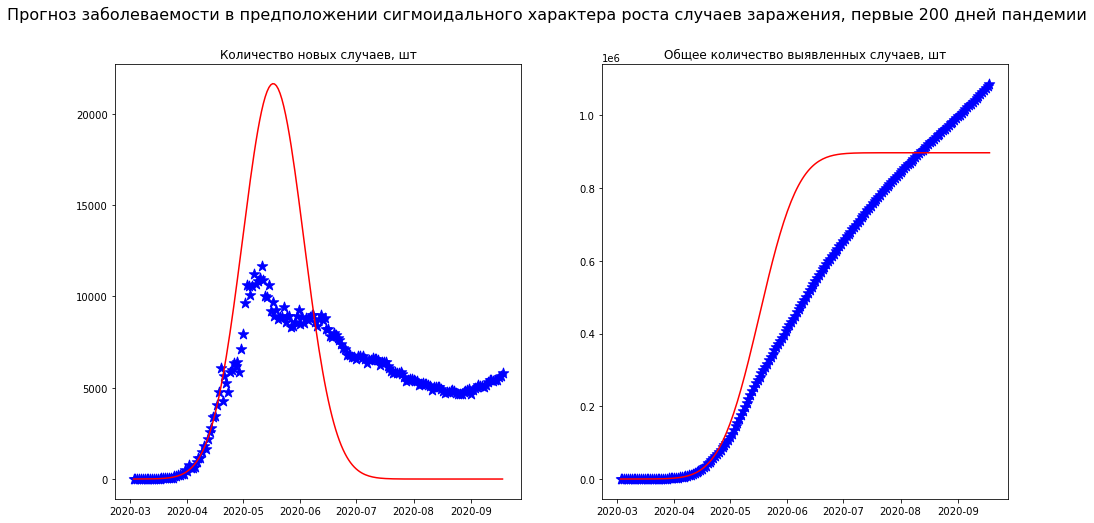

In [98]:
days_for_view = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Прогноз заболеваемости в предположении сигмоидального характера роста случаев заражения, первые 200 дней пандемии', size = 16)

ax1.scatter(data['date'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax1.plot(data['date'][:days_for_view], data['new_cases_pred_sigmoid'][:days_for_view], color = 'red')
ax1.set_title('Количество новых случаев, шт')

ax2.scatter(data['date'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax2.plot(data['date'][:days_for_view], data['total_cases_pred_sigmoid'][:days_for_view], color = 'red')
ax2.set_title('Общее количество выявленных случаев, шт');

***3b. Построение апостериорного распределения параметров модели.***

Как и ранее, делаем базовое предположение, что наши данные ('log_new_cases') порождены линейной моделью от трех переменных ($x^2$, $x$ и $1$) с шумом. Шум имеет нормальное распределение с центром в нуле и дисперсией  $\sigma$.

Оценим sigma на основании отклонений реального и спрогнозированного моделью log_new_cases:

In [90]:
data['pred_log_new_cases'] = y_pred
data['sigma_emp'] = data['pred_log_new_cases'] - data['log_new_cases']
sigma = data[:n_days_for_train].sigma_emp.std()
sigma

0.49413585803292426

Рассчитаем параметры апостериорного распределения по той же логике, что и при построении экспоненциальной модели

In [91]:
mu_prior, sigma_prior = np.array([0, 0, 0]), sigma * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [92]:
X1 = X[:n_days_for_train]
y1 = y[:n_days_for_train]
sigma_post = np.linalg.inv(np.linalg.inv(sigma_prior) + 1 / sigma**2 * X1.T @ X1)
mu_post = sigma_post @ (np.linalg.inv(sigma_prior) @ mu_prior + 1 / sigma**2 * X1.T@y1)

In [93]:
sigma_post

array([[ 3.41436106e-04, -6.56174616e-06, -3.03006752e-03],
       [-6.56174616e-06,  1.35129819e-07,  5.10062422e-05],
       [-3.03006752e-03,  5.10062422e-05,  3.75108036e-02]])

In [94]:
mu_post

array([ 0.27300045, -0.00178519, -0.36479414])

Посмотрим на графике точность аппроксимации:

In [95]:
pred_post = X @ mu_post

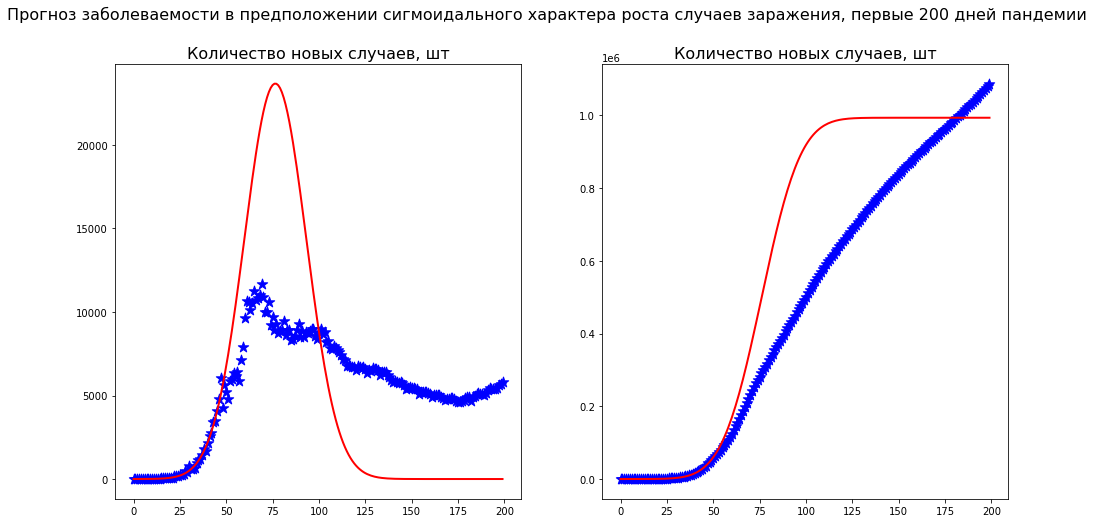

In [99]:
days_for_view = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Прогноз заболеваемости в предположении сигмоидального характера роста случаев заражения, первые 200 дней пандемии', size = 16)

ax1.scatter(data['number_of_the_day'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax1.set_title('Количество новых случаев, шт', size = 16)

ax1.plot(data['number_of_the_day'][:days_for_view], np.exp(pred_post[:days_for_view]), linewidth=2, color = 'red')


ax2.scatter(data['number_of_the_day'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax2.set_title('Количество новых случаев, шт', size = 16)

ax2.plot(data['number_of_the_day'][:days_for_view], np.exp(pred_post[:days_for_view]).cumsum(), linewidth=2, color = 'red');

***3c. Построение предсказательного распределения сигмоидальной модели***

Как и ранее, просэмплируем много разных сигмоид из полученного апостериорного распределения параметров линейной регрессии и построим эмпирическое предсказательное распределение (исходя из данных сэмплирования):

In [100]:
def myplot_sample_sigmoid_model(data, mu, sigma, days_for_view, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111)
    ax.scatter(data['date'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'red')
    ax.set_title('Общее количество зараженных, шт', size = 16)
    
    X = np.vstack([data['number_of_the_day'], data['number_of_the_day'].apply(lambda x: x**2), np.ones(len(data))]).T
    for w in my_w:
        pred_post = X @ w
        ax.plot(data['date'][:days_for_view],  np.exp(pred_post[:days_for_view]).cumsum(), linewidth=1, color = 'black')

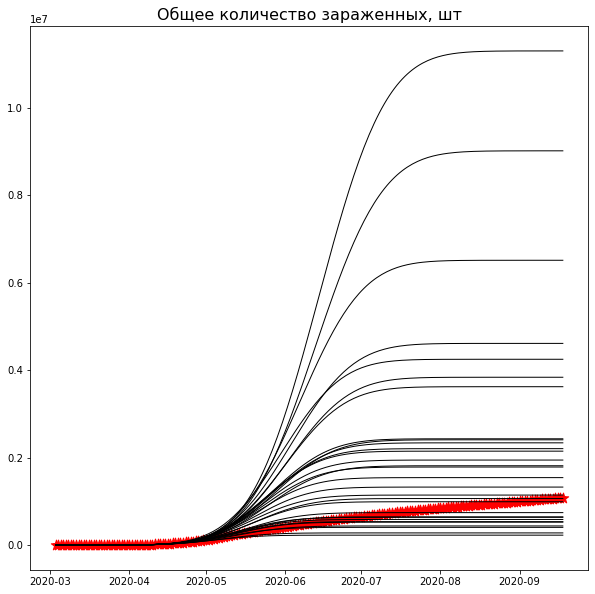

In [101]:
myplot_sample_sigmoid_model(data, mu_post, sigma_post, days_for_view = 200, n = 30)

Построим предсказательное распределение на основе сэмплирования и сделаем оптичистичный и пессимистичный прогноз (10-й и 90-й процентиль в выборке числа случаев соответственно):

In [102]:
def predictive_dist_sigmoid(data, mu, sigma, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    X =np.vstack([data['number_of_the_day'], data['number_of_the_day'].apply(lambda x: x**2), np.ones(len(data))]).T
    preds = []
    for w in my_w:
        pred_post = np.exp(X @ w).cumsum()
        preds.append(pred_post)
    return np.array(preds)

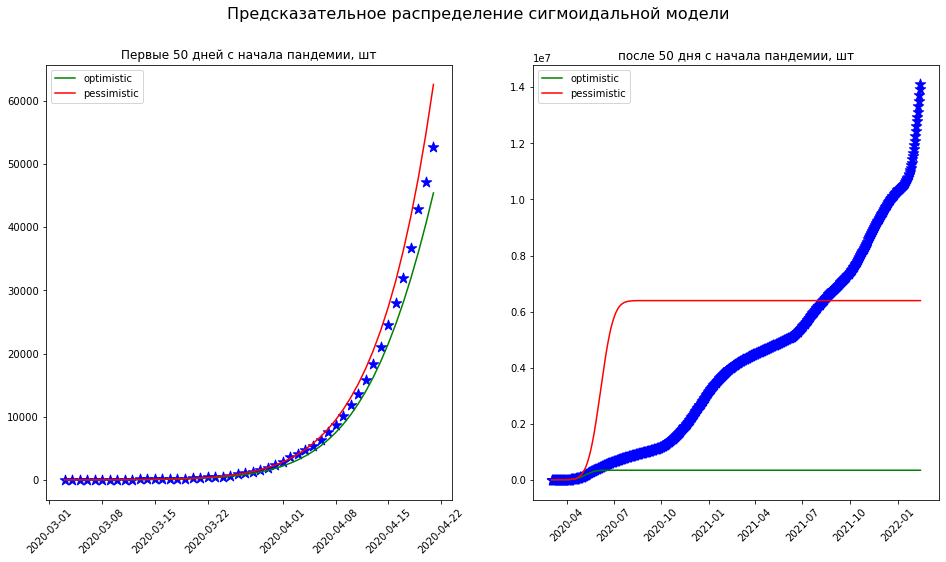

Общее количество зараженных в Швеции в соответствии с оптимистичным вариантом прогноза: 340537 человек
Общее количество зараженных в Швеции в соответствии с пессимистичным вариантом прогноза: 6390985 человек
Общее количество зараженных в Швеции на 14.02.2022: 14102736 человек


In [103]:
n_samples = 100000
preds = predictive_dist_sigmoid(data, mu_post, sigma_post,n_samples)
data['pred_sigmoid_optimistic'] = np.percentile(preds, 10, axis = 0)
data['pred_sigmoid_pessimistic'] = np.percentile(preds, 90, axis = 0)

days_for_view = len(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Предсказательное распределение сигмоидальной модели', size = 16)

ax1.scatter(data.date[:50], data.total_cases[:50], marker='*', s=120, color = 'blue')
ax1.plot(data['date'][:50], data['pred_sigmoid_optimistic'][:50], label = 'optimistic', color = 'green')
ax1.plot(data['date'][:50], data['pred_sigmoid_pessimistic'][:50], label = 'pessimistic', color = 'red')
ax1.set_title('Первые 50 дней с начала пандемии, шт')
ax1.legend(loc="upper left")

ax2.scatter(data.date[0:days_for_view], data.total_cases[0:days_for_view], marker='*', s=120, color = 'blue')
ax2.plot(data['date'][0:days_for_view], data['pred_sigmoid_optimistic'][0:days_for_view], label = 'optimistic', color = 'green')
ax2.plot(data['date'][0:days_for_view], data['pred_sigmoid_pessimistic'][0:days_for_view], label = 'pessimistic', color = 'red')
ax2.set_title('после 50 дня с начала пандемии, шт')
ax2.legend(loc="upper left")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
        
plt.show()

print('Общее количество зараженных в Швеции в соответствии с оптимистичным вариантом прогноза: {} человек'.format(round(data['pred_sigmoid_optimistic'].values[-1])))
print('Общее количество зараженных в Швеции в соответствии с пессимистичным вариантом прогноза: {} человек'.format(round(data['pred_sigmoid_pessimistic'].values[-1])))
print('Общее количество зараженных в Швеции на 14.02.2022: {} человек'.format(round(data['total_cases'].values[-1])))

**Выводы:**

Мы видим большой разброс между оптимистичным и пессимистичным прогнозом. В начале пандемии реальное количество заболевших было ближе к оптимистичному прогнозу, с 2021 года оно начало значительно увеличиваться, а с конца 2021 года даже существенно превысило пессимистичный прогноз, который можно было ожидать на основе модели, построенной на первых 50 днях прогнозирования.

В целом, по прошествии 2-х лет с начала пандемии можно сказать, что  график реального количества заболевших не похож на сигмоиду (если очень постараться, в 2020-первой половине 2021 года можно рассмотреть две идущих друг за другом "сигмоиды", а начиная с осени 2021 года - стремительный рост).
 
Можно обозначить несколько основных причин данной ситуации:
 - Первые 50 дней с начала пандемии - достаточно небольшой промежуток времени для построения точного прогноза на длительный период на будущее (год-два и т.д.). В данном задании прогноз строился только на основе первых 50 дней, чтобы представить себя на месте людей, принимавших решения в момент начала пандемии о необходимости введения ограничений и т.д.
 - Фактическая скорость роста заболевших корректировалась ограничительными мерами, введением локдаунов и т.д. То есть, если бы эпидемия развивалась естественным путем, без внешних влияний, то фактическое количество зараженных, вероятно, было бы существенно выше (и, соответственно, ближе к негативным прогнозируемым значениям)
 - предположение о сигмоидальном характере изменения числа заразившихся, вероятно, распространяется на один и тот же штамм вируса при условии формирования устойчивого иммунитета после выздоровления. В реальности, как известно, было несколько волн эпидемии, вызванных разными штаммами. Эти штаммы обладали разной контагиозностью. Кроме того, оказалось, что через некоторое время после выздоровления возможно повторное заражение.  Таким образом, реальный график заражения не сильно похож на сигмоидальную функцию.
 
Для сравнения проведем аналогичный анализ для Швеции, так как это единственная европейская страна, не вводившая локдаун в первые две волны пандемии. 

### 4. Построение сигмоидальной модели, предсказывающей количество выявленных случаев коронавируса В Швеции.

Для Швеции в качестве дня начала пандемии возьмем 26.02.2020 (когда количество заболевших стало выше 2).

In [104]:
data = pd.read_csv('owid-covid-data.csv')
data = data[data.location == 'Sweden'][['date', 'total_cases', 'new_cases']]
data['date'] = pd.to_datetime(data['date'])
data = data[data.date >= '2020-02-26 00:00:00'].reset_index(drop = True)
data['new_cases'] = data['new_cases'].apply(lambda x: 1 if x == 0 else x)
data['number_of_the_day'] = np.arange(len(data))
data = data[['date', 'number_of_the_day', 'new_cases', 'total_cases']]
data.fillna(0, inplace = True)
data

,date,number_of_the_day,new_cases,total_cases
0,2020-02-26,0,1.0,2.0
1,2020-02-27,1,1.0,3.0
2,2020-02-28,2,8.0,11.0
3,2020-02-29,3,3.0,14.0
4,2020-03-01,4,1.0,14.0
...,...,...,...,...
715,2022-02-10,715,16968.0,2389605.0
716,2022-02-11,716,7725.0,2397330.0
717,2022-02-12,717,0.0,2397330.0
718,2022-02-13,718,0.0,2397330.0


***4а.Обучение параметров сигмоидальной функции с помощью линейной регрессии.***

In [105]:
n_days_for_train = 50

data['log_new_cases'] = np.log(data['new_cases'])
X = np.vstack([data['number_of_the_day'], data['number_of_the_day'].apply(lambda x: x**2), np.ones(len(data))]).T
y = data['log_new_cases'].values

model_sigm = LinearRegression()
model_sigm.fit(X[:n_days_for_train],y[:n_days_for_train])

y_pred = model_sigm.predict(X)
data['new_cases_pred_sigmoid'] = np.exp(y_pred)
data['total_cases_pred_sigmoid'] = data['new_cases_pred_sigmoid'].cumsum()

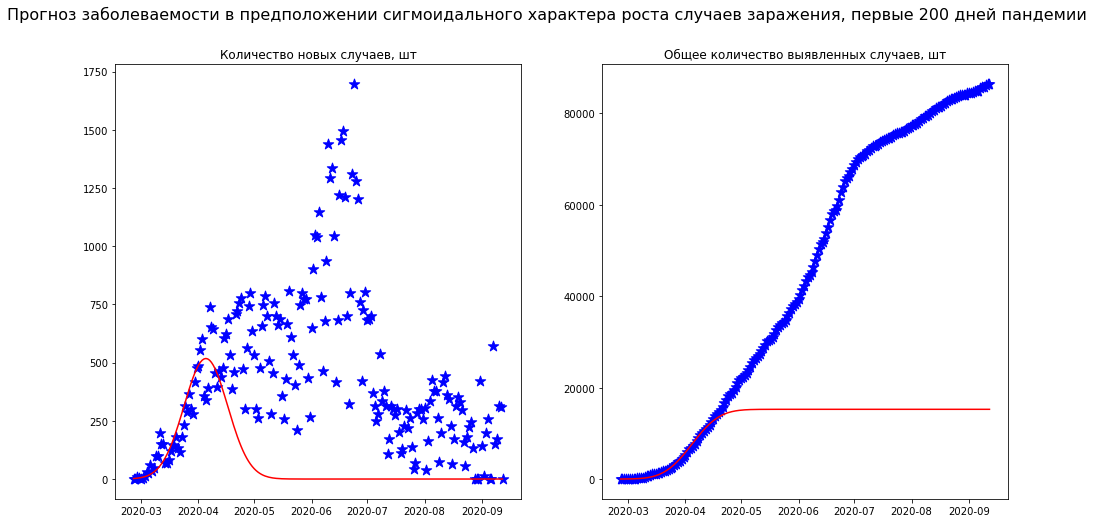

In [106]:
days_for_view = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Прогноз заболеваемости в предположении сигмоидального характера роста случаев заражения, первые 200 дней пандемии', size = 16)

ax1.scatter(data['date'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax1.plot(data['date'][:days_for_view], data['new_cases_pred_sigmoid'][:days_for_view], color = 'red')
ax1.set_title('Количество новых случаев, шт')

ax2.scatter(data['date'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax2.plot(data['date'][:days_for_view], data['total_cases_pred_sigmoid'][:days_for_view], color = 'red')
ax2.set_title('Общее количество выявленных случаев, шт');

Заметно, что без влияния ограничительных мер колиество зараженных увеличивалось значительно быстрее, чем того можно было ожидать в первые 50 дней эпидемии.

***4b. Построение апостериорного распределения***

In [51]:
data['pred_log_new_cases'] = y_pred
data['sigma_emp'] = data['pred_log_new_cases'] - data['log_new_cases']
sigma = data[:n_days_for_train].sigma_emp.std()
mu_prior, sigma_prior = np.array([0, 0, 0]), sigma * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

X1 = X[:n_days_for_train]
y1 = y[:n_days_for_train]
sigma_post = np.linalg.inv(np.linalg.inv(sigma_prior) + 1 / sigma**2 * X1.T @ X1)
mu_post = sigma_post @ (np.linalg.inv(sigma_prior) @ mu_prior + 1 / sigma**2 * X1.T@y1)

In [52]:
pred_post = X @ mu_post

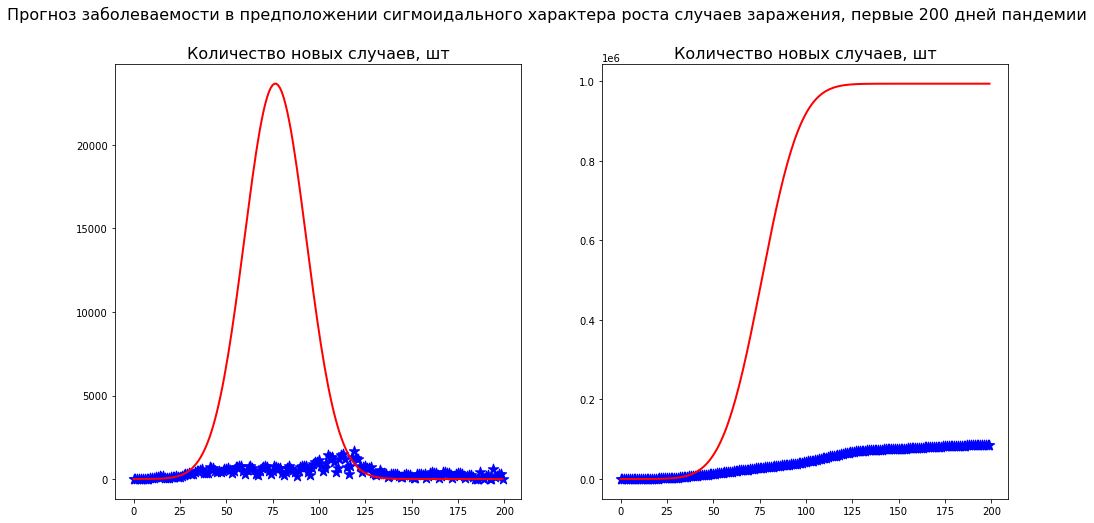

In [107]:
days_for_view = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Прогноз заболеваемости в предположении сигмоидального характера роста случаев заражения, первые 200 дней пандемии', size = 16)

ax1.scatter(data['number_of_the_day'][:days_for_view], data['new_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax1.set_title('Количество новых случаев, шт', size = 16)

ax1.plot(data['number_of_the_day'][:days_for_view], np.exp(pred_post[:days_for_view]), linewidth=2, color = 'red')


ax2.scatter(data['number_of_the_day'][:days_for_view], data['total_cases'][:days_for_view], marker='*', s=120, color = 'blue')
ax2.set_title('Количество новых случаев, шт', size = 16)

ax2.plot(data['number_of_the_day'][:days_for_view], np.exp(pred_post[:days_for_view]).cumsum(), linewidth=2, color = 'red');

***4b. Построение предсказательного распределения***

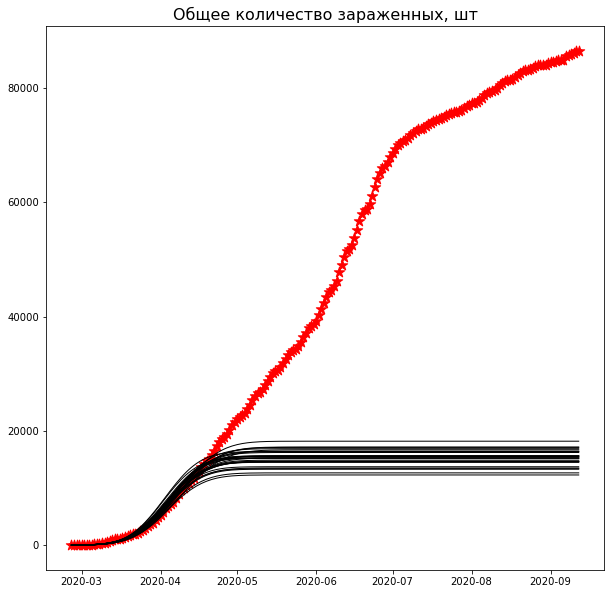

In [54]:
myplot_sample_sigmoid_model(data, mu_post, sigma_post, days_for_view = 200, n = 30)

В отличии от России, где сигмоиды, сэмплированные из апостериорного распределения, часто лежали значительно выше фактического количества зараженных, в Швеции реальное количество зараженных оказалось намного выше, чем прогнозировалось по сэмплированным сигмоидам.

Оптимистичный и пессимистичный прогноз на основе сэмплированных сигмоид:

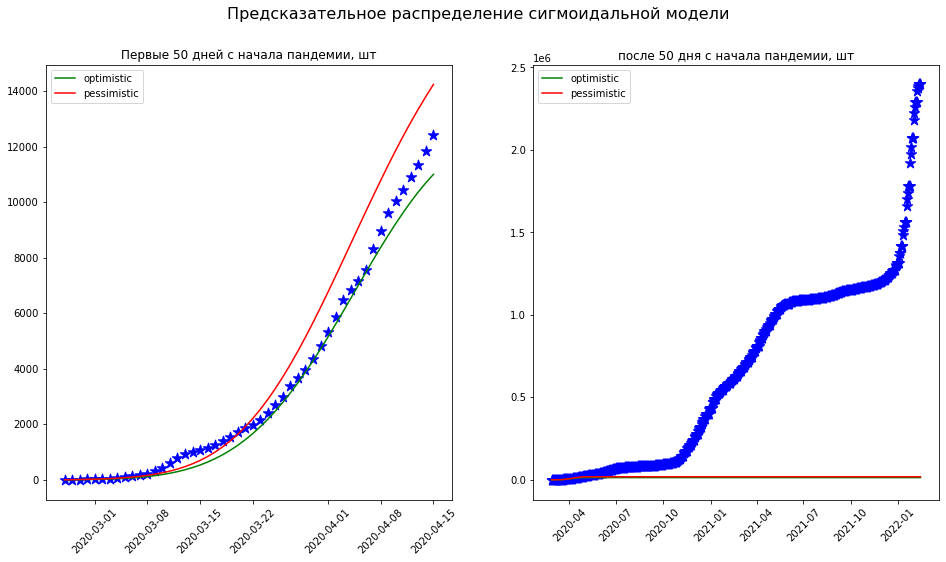

Общее количество зараженных в Швеции в соответствии с оптимистичным вариантом прогноза: 13112 человек
Общее количество зараженных в Швеции в соответствии с пессимистичным вариантом прогноза: 18283 человек
Общее количество зараженных в Швеции на 14.02.2022: 2397330 человек


In [55]:
n_samples = 100000
preds = predictive_dist_sigmoid(data, mu_post, sigma_post,n_samples)
data['pred_sigmoid_optimistic'] = np.percentile(preds, 10, axis = 0)
data['pred_sigmoid_pessimistic'] = np.percentile(preds, 90, axis = 0)

days_for_view = len(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

fig.suptitle('Предсказательное распределение сигмоидальной модели', size = 16)

ax1.scatter(data.date[:50], data.total_cases[:50], marker='*', s=120, color = 'blue')
ax1.plot(data['date'][:50], data['pred_sigmoid_optimistic'][:50], label = 'optimistic', color = 'green')
ax1.plot(data['date'][:50], data['pred_sigmoid_pessimistic'][:50], label = 'pessimistic', color = 'red')
ax1.set_title('Первые 50 дней с начала пандемии, шт')
ax1.legend(loc="upper left")

ax2.scatter(data.date[0:days_for_view], data.total_cases[0:days_for_view], marker='*', s=120, color = 'blue')
ax2.plot(data['date'][0:days_for_view], data['pred_sigmoid_optimistic'][0:days_for_view], label = 'optimistic', color = 'green')
ax2.plot(data['date'][0:days_for_view], data['pred_sigmoid_pessimistic'][0:days_for_view], label = 'pessimistic', color = 'red')
ax2.set_title('после 50 дня с начала пандемии, шт')
ax2.legend(loc="upper left")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
        
plt.show()

print('Общее количество зараженных в Швеции в соответствии с оптимистичным вариантом прогноза: {} человек'.format(round(data['pred_sigmoid_optimistic'].values[-1])))
print('Общее количество зараженных в Швеции в соответствии с пессимистичным вариантом прогноза: {} человек'.format(round(data['pred_sigmoid_pessimistic'].values[-1])))
print('Общее количество зараженных в Швеции на 14.02.2022: {} человек'.format(round(data['total_cases'].values[-1])))

В Швеции даже в 2020-первой половине 2021 года фактическое количество зараженных оказалось значительно выше, чем можно было ожидать на основе первых 50 дней пандемии (даже в пессимистичном прогнозе).
Безусловно, тут может играть роль качество собираемой статистики по зараженным (есть мнение, что в РФ эти данные существенно занижены), но, тем не менее, на основе анализа этих двух стран, можно сделать вывод, что введение ограничительных мер было оправдано в плане снижения количества заболевших.